In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas

## CREATE DATA

In [2]:
x = torch.linspace(0,799, 800)
x

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
        144., 145., 146., 147., 148., 14

In [3]:
y = torch.sin(x*2*3.1416/40)

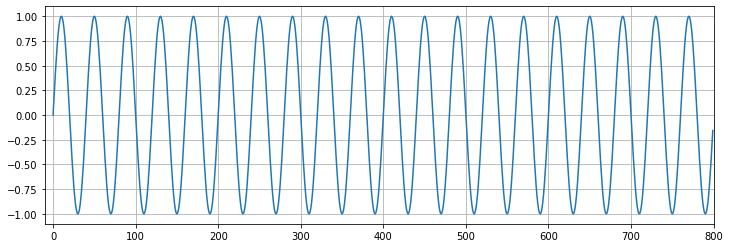

In [4]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(y.numpy())

## SPLIT TRAIN AND TEST DATA

In [5]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

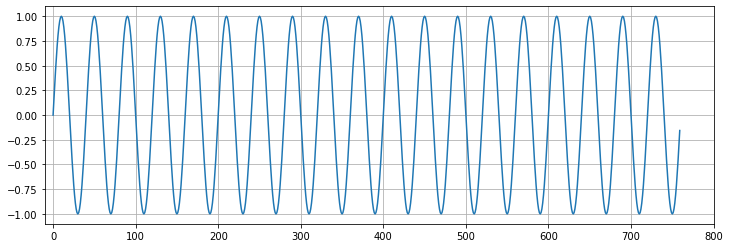

In [6]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(train_set.numpy())

## SPLIT TRAIN DATA INTO MINI-BATCHES (CUSTOM DATALOADER)

In [7]:
def input_data(seq, ws): #seq = training sequence, ws = window_size
    out = [] #([0,1,2,3],[4]), ([1,2,3,4],[5]), ...
    L = len(seq)
    
    for i in range(L-ws):
        
        window = seq[i:i+ws]
        label = seq[i+ws: i+ws+1]
        
        out.append((window, label))
    
    return out

In [8]:
window_size = 40

train_data = input_data(train_set, window_size)

In [9]:
len(train_data) #0-799 ==> 800 | 800-40 ==> 760 | #760-40 ==> 720

720

In [10]:
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

## MODEL (LSTM)

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)
        
        #(HIDDEN, CELL)
        self.hidden = (torch.zeros(1,1, hidden_size), torch.zeros(1,1, hidden_size))
        
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq), -1))
        
        #Out just last item
        return pred[-1]

## CRITERION/ OPTIMIZER

In [12]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [13]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [14]:
numel = 0
for p in model.parameters():
    numel += (p.numel())
    print(p.numel())
print(numel)

200
10000
200
200
50
1
10651


## TRAIN AND TEST

Epoch 0 Loss: 0.09212876856327057
Test Loss: 0.6071589589118958


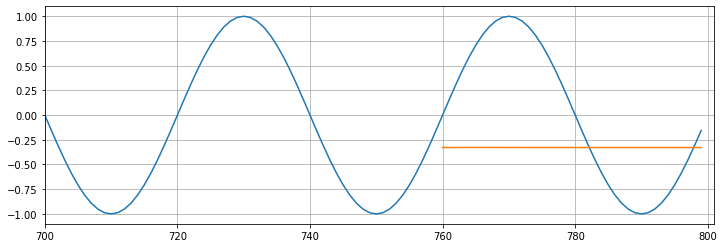

Epoch 1 Loss: 0.06506765633821487
Test Loss: 0.5650987029075623


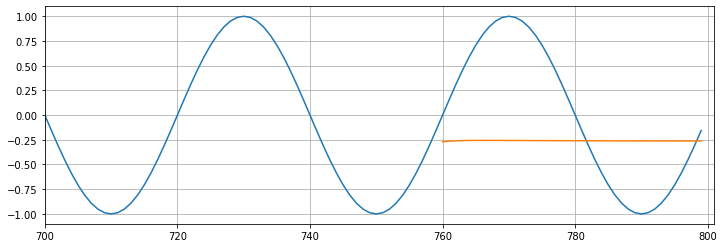

Epoch 2 Loss: 0.04198049008846283
Test Loss: 0.5199716687202454


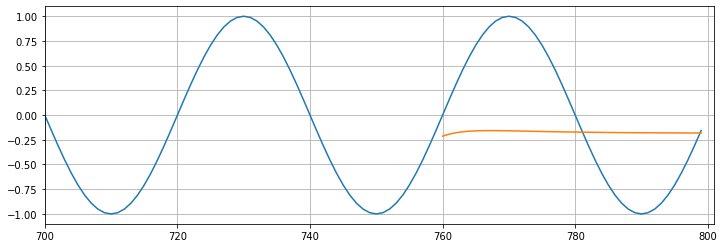

Epoch 3 Loss: 0.017842771485447884
Test Loss: 0.4220997393131256


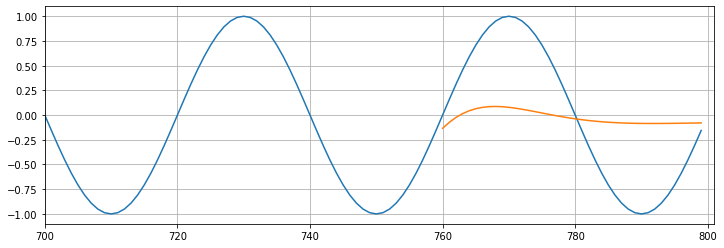

Epoch 4 Loss: 0.0028870997484773397
Test Loss: 0.16624143719673157


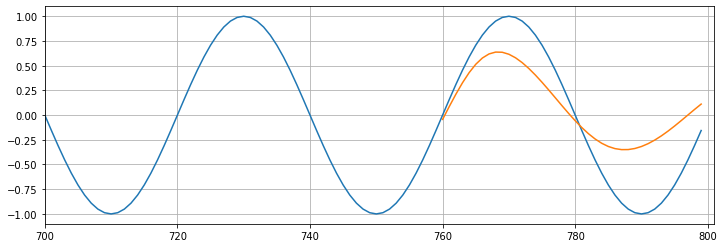

Epoch 5 Loss: 0.00032007633126340806
Test Loss: 0.03055434301495552


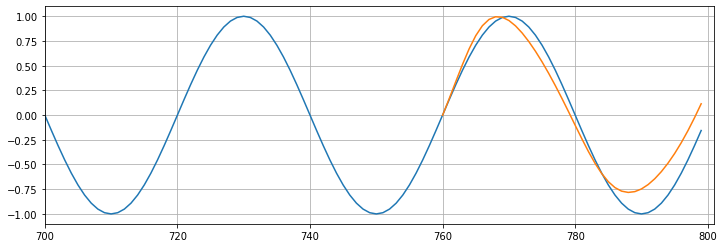

Epoch 6 Loss: 0.00012969138333573937
Test Loss: 0.014990203082561493


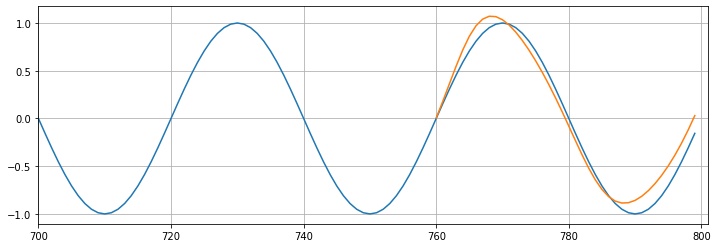

Epoch 7 Loss: 0.00012006668112007901
Test Loss: 0.011856656521558762


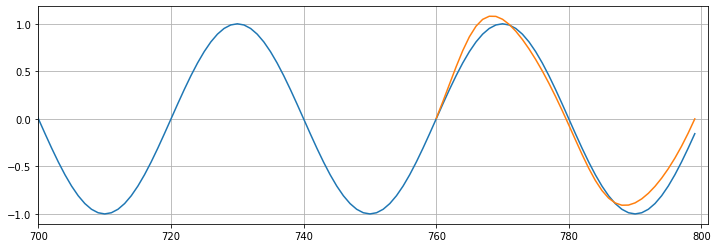

Epoch 8 Loss: 0.00012655690079554915
Test Loss: 0.010163831524550915


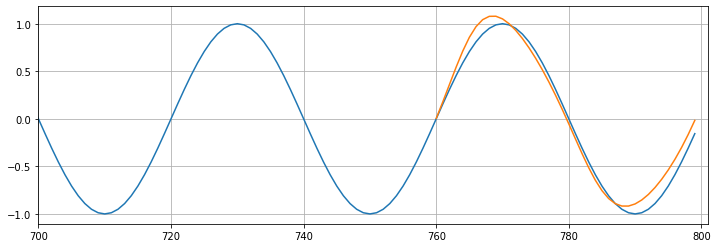

Epoch 9 Loss: 0.0001319547591265291
Test Loss: 0.00889758300036192


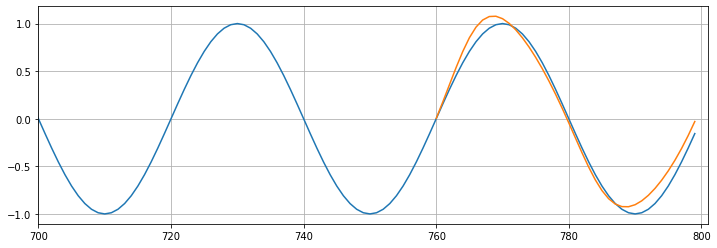

In [15]:
epochs = 10
future = 40

for i in range(epochs):
    
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size)
        
        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {i} Loss: {loss.item()}')
    
    preds = train_set[-window_size:].tolist()
    
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size)
            preds.append(model(seq).item())
            
    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f'Test Loss: {loss}')
    
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800), preds[window_size:])
    plt.show()